In [1]:
!pip install gymnasium[all]
!pip install numpy matplotlib
!pip install stable-baselines3
!pip install yfinance 
!pip install pandas
!pip install shimmy 

  Using cached numpy-2.4.2-cp312-cp312-win_amd64.whl.metadata (6.6 kB)
  Using cached numpy-2.3.5-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.


In [2]:
!pip install "numpy<2"

  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.9.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.9.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


[                       0%                       ]

[*********************100%***********************]  4 of 4 completed


Training Agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 799      |
|    ep_rew_mean     | 48.7     |
| time/              |          |
|    fps             | 372      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 799        |
|    ep_rew_mean          | 50.6       |
| time/                   |            |
|    fps                  | 312        |
|    iterations           | 2          |
|    time_elapsed         | 13         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00572556 |
|    clip_fraction        | 0.0152     |
|    clip_range           | 0.2        |
|    entropy_lo

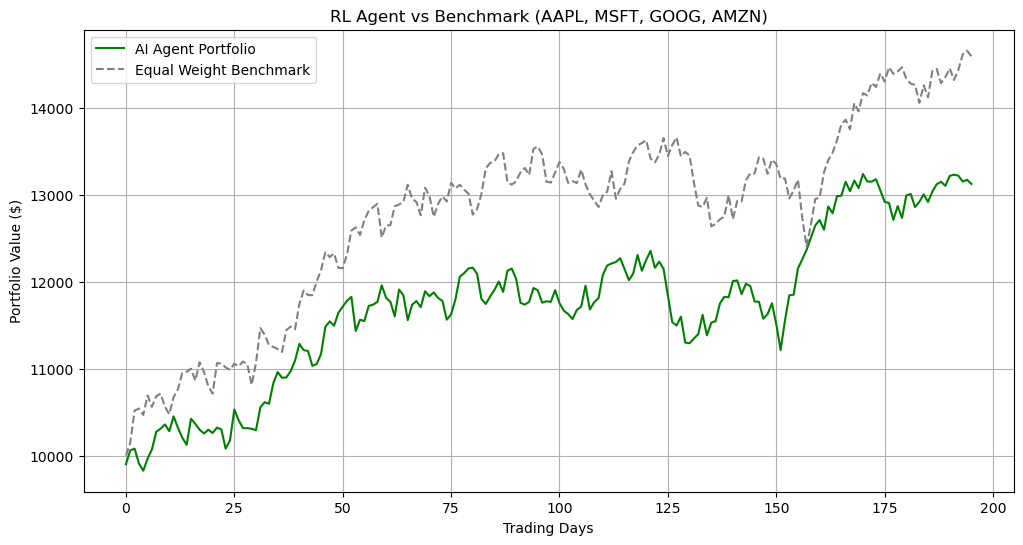

In [ ]:
import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO



#  SETUP: Data 4 stocks 
# ==========================================
def download_data(tickers, start_date, end_date):
   
    print(f"Downloading data for: {tickers}")
    
    
    df = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
    
   
    try:
        data = df['Close']
    except KeyError:
        
        print("Note: 'Close' key not found, attempting to use data directly.")
        data = df
        
    return data.dropna()

# PLATFORM: Custom RL Environment
# ==========================================
class PortfolioEnv(gym.Env):
    

    def __init__(self, data):
        super(PortfolioEnv, self).__init__()
        self.df = data
        self.tickers = data.columns.tolist()
        self.n_assets = len(self.tickers)


        self.action_space = spaces.Box(low=-1, high=1, shape=(self.n_assets,), dtype=np.float32)


        self.window_size = 5
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.window_size, self.n_assets),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.done = False
        self.portfolio_value = 10000.0  
        self.history = {'portfolio_value': [], 'market_return': []}
        return self._get_observation(), {}

    def _get_observation(self):
        # Return the daily returns 
        window_data = self.df.iloc[self.current_step - self.window_size: self.current_step]
        returns = window_data.pct_change().fillna(0).values
        return returns.astype(np.float32)

    def step(self, action):
        # 1. Convert Agent's raw action into portfolio weights (Softmax)
        # e.g., Action [2.0, 1.0] -> Weights [0.73, 0.27]
        exp_action = np.exp(action)
        weights = exp_action / np.sum(exp_action)

        # 2. Calculate Return for the *next* day based on these weights
        
        if self.current_step >= len(self.df) - 1:
            self.done = True
            return self._get_observation(), 0, True, False, {}

        # Calculate the percent change of assets for the next day
        current_prices = self.df.iloc[self.current_step].values
        next_prices = self.df.iloc[self.current_step + 1].values
        asset_returns = (next_prices - current_prices) / current_prices

        # Portfolio return = sum(weight * asset_return)
        portfolio_return = np.sum(weights * asset_returns)

        # Update Portfolio Value
        self.portfolio_value *= (1 + portfolio_return)

        # Agent tries to maximize this
        reward = portfolio_return * 100  # Scale up for better learning stability

        
        self.current_step += 1

        # Track history for plotting
        self.history['portfolio_value'].append(self.portfolio_value)

        return self._get_observation(), reward, self.done, False, {}



#  EXECUTION: Train & Analyze


# A. Configuration
#Stock examples 
TICKERS = ['AAPL', 'MSFT', 'GOOG', 'AMZN']  
START_DATE = '2020-01-01'
END_DATE = '2024-01-01'

# B. Prepare Data
data = download_data(TICKERS, START_DATE, END_DATE)
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# C. Train the Agent
print("Training Agent...")
env = PortfolioEnv(train_data)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=20000) 

# D. Analysis Platform (Backtest)
print("\nRunning Analysis on Test Data...")
test_env = PortfolioEnv(test_data)
obs, _ = test_env.reset()
done = False

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = test_env.step(action)


# VISUALIZATION
# ==============================================
print("Plotting Results...")
plt.figure(figsize=(12, 6))

# Get Agent Performance
agent_values = test_env.history['portfolio_value']

# Calculate "Buy and Hold" Benchmark (Equal Weight) for comparison
test_returns = test_data.pct_change().fillna(0)
equal_weights = np.array([1 / len(TICKERS)] * len(TICKERS))
benchmark_values = [10000.0]
for i in range(len(test_returns) - 1):  # Match length of agent steps
    daily_ret = np.sum(test_returns.iloc[i + 1].values * equal_weights)
    benchmark_values.append(benchmark_values[-1] * (1 + daily_ret))

# Plot
plt.plot(agent_values, label="AI Agent Portfolio", color='green')
plt.plot(benchmark_values[:len(agent_values)], label="Equal Weight Benchmark", color='gray', linestyle='--')
plt.title(f"RL Agent vs Benchmark ({', '.join(TICKERS)})")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()